In [1]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from src.c_country import C_Country
from utils.graph_generator import get_path
from utils.dotdict import dotdict
from utils.params import init_graph, get_centrum
from utils.params import GIRG_args1,GIRG_args2,GIRG_args3,GIRG_args4, get_moving


import seaborn as sn
import matplotlib.pyplot as plt
sn.set_theme(style="whitegrid")

import pickle

TODO:
* edge_th -> 25

In [2]:
args = {
    "--p_moving": 0.015, 
    "--p_worker": 1.0, 
    "--beta": 0.5,
    "--beta_super":0.0, 
    "--seed": 0,
    "--sigma": 1.0, 
    "--gamma": 0.2,
    "--max_sim": 500,
    "inf_agent_num":5000,
}

KSH_args = dotdict({
    "name": "KSH",
    "th":{
        "node":1000,
        "edge":25,
        "node_factor": 1,
        "edge_factor": 1,
    },
    "transform":{
        "equal_pop": False,
        "equal_edge":False,
        "shuffle_edges":False,
    }
})

In [3]:
import pandas as pd
def save_to_file(betas, agg1, agg2, seed, filename):
    df = pd.DataFrame()
    for beta,sims in zip(betas,agg1):
        row = {"sim"+str(i):v for i,v in enumerate(sims)}
        row["beta"]=beta
        row["cen"]=True
        df = df.append(row, ignore_index=True)
    for beta,sims in zip(betas,agg2):
        row = {"sim"+str(i):v for i,v in enumerate(sims)}
        row["beta"]=beta
        row["cen"]=False
        df=df.append(row, ignore_index=True)
    df.to_csv(filename)

In [4]:
def get_outgoing_weight(graph):
    deg_dict = {}
    for node in graph.nodes:
        out = 0
        inp = 0
        for neigh in graph.successors(node):
            out+= graph[node][neigh]["weight"]
        for neigh in graph.predecessors(node):
            inp += graph[neigh][node]["weight"]
        pop = float(graph.nodes[node]["population"])
        deg_dict[node] = (out/pop, inp/pop)
    return deg_dict

def bound_outgoing_from_city(graph, deg_dict, proc):
    for u,v in graph.edges:
        # On the outgoing edges the sum should be proc
        graph[u][v]["weight"] *= (proc/deg_dict[u][0])
    return graph

def homogene_outgoing(graph, deg_dict):
    for u,v in graph.edges:
        # On the outgoing edges the sum should be proc
        pop = float(graph.nodes[u]["population"])
        #graph[u][v]["weight"] = float(0.1*pop)        
        graph[u][v]["weight"] = (1.0/graph.out_degree[u])*deg_dict[u][0]*pop
    return graph

def shuffle_g(graph):
    w = sum(dict(nx.get_edge_attributes(graph, "weight")).values())
    pop = sum(dict(nx.get_node_attributes(graph, "population")).values())
    swap_num = len(graph.edges())*10
    graph = nx.Graph(graph)
    n = nx.algorithms.swap.connected_double_edge_swap(graph, nswap=swap_num)
    for u,v in graph.edges:
        graph[u][v]["weight"]=w/len(graph.edges)
    for node in graph.nodes:
        graph.nodes[node]["population"]=int(pop/len(graph.nodes))
    return graph

def make_undirectred(graph):
    weights = nx.get_edge_attributes(graph, "weight")
    for u,v in weights:
        w = weights[(u,v)] if (v,u) not in weights else (weights[(u,v)]+weights[(v,u)])/2 
        graph[u][v]["weight"] = w
        if((v,u) not in weights):
            graph.add_edge(v,u,weight=w)
        else:
            graph[v][u]["weight"] = w
    return graph

In [5]:

def get_pest(graph):
    pest = ["Alsónémedi","Biatorbágy","Budajenő","Budakalász","Budakeszi","Budaörs","Csobánka","Csomád","Csömör","Csörög","Dabas","Délegyháza","Diósd","Dunabogdány","Dunaharaszti","Dunakeszi","Dunavarsány","Ecser","Erdőkertes","Érd","Felsőpakony","Fót","Göd","Gödöllő","Gyál","Gyömrő","Halásztelek","Herceghalom","Inárcs","Isaszeg","Kakucs","Kerepes","Kistarcsa","Kisoroszi","Leányfalu","Majosháza","Maglód","Mogyoród","Monor","Nagykovácsi","Nagytarcsa","Ócsa","Őrbottyán","Páty","Perbál","Pécel","Pilisborosjenő","Piliscsaba","Pilisjászfalu","Pilisszántó","Pilisszentiván","Pilisszentkereszt","Pilisszentlászló","Pilisvörösvár","Pomáz","Pócsmegyer","Pusztazámor","Remeteszőlős","Solymár","Sóskút","Szada","Százhalombatta","Szentendre","Szigethalom","Szigetmonostor","Szigetszentmiklós","Sződ","Sződliget","Tahitótfalu","Taksony","Tárnok","Telki","Tinnye","Tök","Tököl","Törökbálint","Újhartyán","Újlengyel","Üllő","Üröm","Vác","Vácrátót","Vecsés","Veresegyház","Visegrád","Zsámbék"
          ]
    for i in range(1,10):
        pest.append('Budapest 0{}. ker.'.format(i))
    for i in range(10, 24):
        pest.append('Budapest {}. ker.'.format(i))
        
    return [n for n in graph.nodes if city_names[n] in pest]


In [6]:
graph = init_graph(KSH_args)
city_names = nx.get_node_attributes(graph, "city_name")

pest = get_pest(graph)
print([graph.nodes[n]["city_name"] for n in pest], len(pest))

Directed
Number of cities:  1396
Graph nodes:  1396
Poulation:  9208810
['Telki', 'Budapest 14. ker.', 'Budapest 06. ker.', 'Pilisszentlászló', 'Pócsmegyer', 'Százhalombatta', 'Vácrátót', 'Biatorbágy', 'Mogyoród', 'Budapest 03. ker.', 'Veresegyház', 'Dabas', 'Dunakeszi', 'Pilisszentkereszt', 'Pilisszántó', 'Budapest 01. ker.', 'Dunaharaszti', 'Halásztelek', 'Újlengyel', 'Budapest 04. ker.', 'Délegyháza', 'Budapest 17. ker.', 'Nagykovácsi', 'Dunavarsány', 'Budapest 22. ker.', 'Szada', 'Monor', 'Budapest 10. ker.', 'Majosháza', 'Maglód', 'Csömör', 'Budapest 20. ker.', 'Budapest 15. ker.', 'Alsónémedi', 'Budaörs', 'Pilisszentiván', 'Nagytarcsa', 'Budakalász', 'Göd', 'Diósd', 'Újhartyán', 'Budapest 13. ker.', 'Ecser', 'Tök', 'Üröm', 'Pomáz', 'Budapest 12. ker.', 'Vác', 'Budakeszi', 'Zsámbék', 'Budapest 19. ker.', 'Dunabogdány', 'Budapest 08. ker.', 'Gyál', 'Pécel', 'Ócsa', 'Szigetmonostor', 'Tárnok', 'Csobánka', 'Sóskút', 'Vecsés', 'Törökbálint', 'Budapest 21. ker.', 'Szigethalom', 'Budape

In [7]:
betas = np.concatenate(
    (np.linspace(0.95*args["--gamma"], 1.05*args["--gamma"], 12),
     np.linspace(1.05*args["--gamma"], 1.3*args["--gamma"], 10)[1:])
)
#betas = np.linspace(args["--gamma"], 1.3*args["--gamma"], 16)
betas = np.linspace(0.9*args["--gamma"], 0.95*args["--gamma"], 4)
args["--p_moving"]=0.05
args["procnum"] = 30
args["simnum"] = 150

In [8]:
INF_CITY = len(pest)

# Measure 0 : directred

In [11]:
import os
log_folder = "data/simulations"
if(not os.path.exists(log_folder)):
    os.makedirs(log_folder)


In [12]:
graph = init_graph(KSH_args)

Directed
Number of cities:  1396
Graph nodes:  1396
Poulation:  9208810


In [ ]:
%time
inf_city = INF_CITY
hun = C_Country(graph)
    
centrum = pest
#agg_dir_bp,cities1 = hun.run_for_betas_simple(args, centrum, betas, inf_city, "uniform_random")
agg_dir_bp = hun.run_for_betas_simple_raw(args, centrum, betas, inf_city, "uniform_random")

periphery = [n for n in graph.nodes() if n not in []] 
#agg_dir_per,cities2 = hun.run_for_betas_simple(args, periphery, betas, inf_city, "uniform_random")
agg_dir_per = hun.run_for_betas_simple_raw(args, periphery, betas, inf_city, "uniform_random")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.7 µs
 473/600

In [ ]:
label = "directed"
agg1 = agg_dir_bp
agg2 = agg_dir_per

filename = "{}/KSH_{}_nodeTh:{}_edgeTh:{}.csv".format(
    log_folder, label,KSH_args["th"]["node"], KSH_args["th"]["edge"])
save_to_file(betas, agg1, agg2, 0, filename)

# Homogene outgoing

In [34]:
graph = init_graph(KSH_args)
deg_dict = get_outgoing_weight(graph)
homogene_outgoing(graph, deg_dict)

Directed
Number of cities:  1396
Graph nodes:  1396
Poulation:  9208810


In [35]:
%time
inf_city = INF_CITY
hun = C_Country(graph)

centrum = pest
agg_homedge_bp = hun.run_for_betas_simple_raw(args, centrum, betas, inf_city, "uniform_random")

periphery = [n for n in graph.nodes() if n not in []] 
agg_homedge_per = hun.run_for_betas_simple_raw(args, periphery, betas, inf_city, "uniform_random")


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
 600/600

In [36]:
label = "homedge"
agg1 = agg_homedge_bp
agg2 = agg_homedge_per

filename = "{}/KSH_{}_nodeTh:{}_edgeTh:{}.csv".format(
    log_folder, label,KSH_args["th"]["node"], KSH_args["th"]["edge"])
save_to_file(betas, agg1, agg2, 0, filename)

# Hom edge, Hom out, equal pop

In [37]:
graph = init_graph(KSH_args)
avg_pop = np.mean(list(dict(nx.get_node_attributes(graph, "population")).values()))
avg_weight = np.mean(list(dict(nx.get_edge_attributes(graph, "weight")).values()))

for n in graph.nodes:
    graph.nodes[n]["population"] = int(avg_pop)
#print(graph[0])

# === Hom out ===
deg_dict = get_outgoing_weight(graph)
avg_out = np.mean(list(deg_dict.values()))
graph = bound_outgoing_from_city(graph, deg_dict, avg_out)
print(avg_out)

# === Hom edge ===
deg_dict = get_outgoing_weight(graph)
print(np.mean(list(deg_dict.values())))
graph = homogene_outgoing(graph, deg_dict)
#print(graph[0])


Directed
Number of cities:  1396
Graph nodes:  1396
Poulation:  9208810
0.1840637548848742
0.1839319040575928


In [38]:
%time
inf_city = INF_CITY
hun = C_Country(graph)

centrum = pest
agg_homall_bp = hun.run_for_betas_simple_raw(args, centrum, betas, inf_city, "uniform_random")

periphery = [n for n in graph.nodes() if n not in []] 
agg_homall_per = hun.run_for_betas_simple_raw(args, periphery, betas, inf_city, "uniform_random")


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.11 µs
 600/600

In [39]:
label = "homall"
agg1 = agg_homall_bp
agg2 = agg_homall_per

filename = "{}/KSH_{}_nodeTh:{}_edgeTh:{}.csv".format(
    log_folder, label,KSH_args["th"]["node"],
    KSH_args["th"]["edge"])
save_to_file(betas, agg1, agg2, 0, filename)

# Shuffle

In [40]:
graph_orig = init_graph(KSH_args)
avg_pop = np.mean(list(dict(nx.get_node_attributes(graph_orig, "population")).values()))

graph = shuffle_g(graph_orig)
graph = graph.to_directed()

for n in graph.nodes:
    graph.nodes[n]["population"] = int(avg_pop)
#print(graph[0])

# === Hom out ===
deg_dict = get_outgoing_weight(graph)
avg_out = np.mean(list(deg_dict.values()))
graph = bound_outgoing_from_city(graph, deg_dict, avg_out)
print(avg_out)

# === Hom edge ===
deg_dict = get_outgoing_weight(graph)
print(np.mean(list(deg_dict.values())))
graph = homogene_outgoing(graph, deg_dict)
#print(graph[0])

Directed
Number of cities:  1396
Graph nodes:  1396
Poulation:  9208810
0.3681275097697485
0.3681275097697485


In [ ]:
%time
inf_city = INF_CITY
hun = C_Country(graph)
    
centrum = pest
#centrum = get_centrum(graph, "k-core", inf_city)
agg_shuffle_bp = hun.run_for_betas_simple_raw(args, centrum, betas, inf_city, "uniform_random")

#periphery = [n for n in graph.nodes() if n not in centrum] 
periphery = [n for n in graph.nodes() if n not in []] 
agg_shuffle_per = hun.run_for_betas_simple_raw(args, periphery, betas, inf_city, "uniform_random")


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 8.82 µs
 553/600

In [ ]:
label = "shuffle"
agg1 = agg_shuffle_bp
agg2 = agg_shuffle_per

filename = "{}/KSH_{}_nodeTh:{}_edgeTh:{}.csv".format(
    log_folder, label,KSH_args["th"]["node"], KSH_args["th"]["edge"])
save_to_file(betas, agg1, agg2, 0, filename)

# All togeather

In [43]:
def save_file(df, file):
    df_cen = df[df["cen"]==True].drop(['beta', 'cen'], axis=1).mean(1)
    df_per = df[df["cen"]==False].drop(['beta', 'cen'], axis=1).mean(1)
    betas = df[df["cen"]==True]["beta"]

    df_agg = pd.DataFrame()
    df_agg["betas"]=df[df["cen"]==True]["beta"]
    df_agg["mean1"]=df_cen
    df_agg["std1"]=df[df["cen"]==True].drop(['beta', 'cen'], axis=1).std(1)
    df_agg["mean2"]=np.array(df_per)
    df_agg["std2"]=np.array(df[df["cen"]==False].drop(['beta', 'cen'], axis=1).std(1))
    df_agg["ratio"]=df_agg["mean1"]/df_agg["mean2"]
    A = 1.645/np.sqrt(df.drop(['beta', 'cen'], axis=1).shape[1])
    df_agg["conf1_lower"] = df_agg["mean1"]-df_agg["std1"]*A
    df_agg["conf1_upper"] = df_agg["mean1"]+df_agg["std1"]*A
    df_agg["conf2_lower"] = df_agg["mean2"]-df_agg["std2"]*A
    df_agg["conf2_upper"] = df_agg["mean2"]+df_agg["std2"]*A
    df_agg["lower"] = df_agg["conf1_lower"]/df_agg["conf2_upper"]
    df_agg["upper"] = df_agg["conf1_upper"]/df_agg["conf2_lower"]

    df_agg.to_csv(log_folder+"/"+file+"_agg.csv")
    
    return df_agg

In [44]:
betas

array([0.18      , 0.18333333, 0.18666667, 0.19      ])

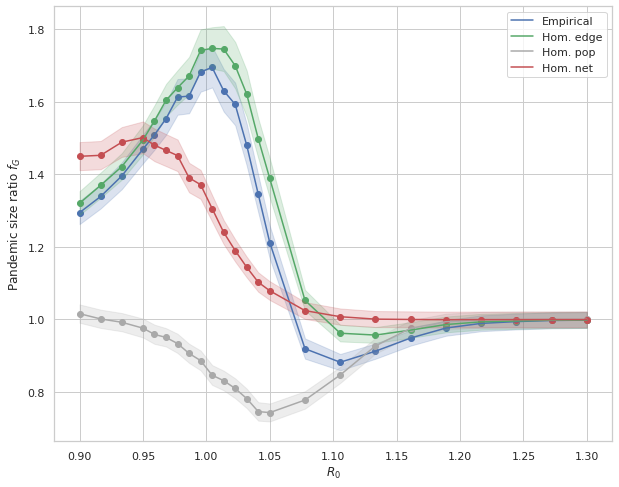

In [93]:
plt.figure(figsize=(10,8))

for label,label2,c in zip(["directed", "homedge", "homall", "shuffle"],
                          ["Empirical", "Hom. edge", "Hom. pop", "Hom. net"],
                         ["b", "g", "darkgrey", "r"]):
    df = pd.read_csv("{}/KSH_{}_nodeTh:{}_edgeTh:{}.csv".format(
        log_folder, label,KSH_args["th"]["node"], 25))
    
    df_old = pd.read_csv("simulations_5000seed/KSH_{}_nodeTh:{}_edgeTh:{}.csv".format(
        label,KSH_args["th"]["node"], 25))
    df=df.append(df_old[df_old['beta']!=0.19])
    #print(len(df_old))
    #print(df_old)
    #print(df)
    
    df.to_csv("simulations/"+label+"_all.csv")
    df_agg = save_file(df, label)
    betas = df_agg["betas"].values

    
    plt.plot(betas/args["--gamma"], df_agg["ratio"].values, label=label2, color=c)
    plt.fill_between(betas/args["--gamma"], df_agg["lower"].values, df_agg["upper"].values,
                     alpha=0.2, color=c)
    plt.scatter(betas/args["--gamma"], df_agg["ratio"].values, color=c)
    
plt.xlabel(r"$R_0$")
plt.ylabel(r"Pandemic size ratio $f_G$")
plt.legend()
plt.show()

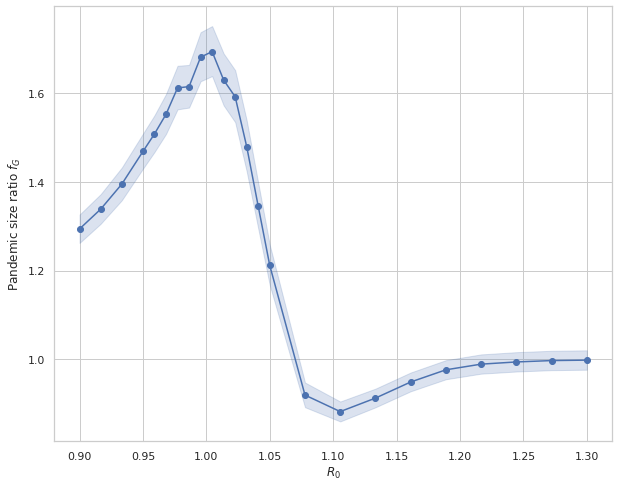

In [79]:
plt.figure(figsize=(10,8))

for label in ["directed"]:    
    df = pd.read_csv("{}/KSH_{}_nodeTh:{}_edgeTh:{}.csv".format(
        log_folder, label,KSH_args["th"]["node"], 25))
    
    df_old = pd.read_csv("simulations_5000seed/KSH_{}_nodeTh:{}_edgeTh:{}.csv".format(
        label,KSH_args["th"]["node"], 25))
    df=df.append(df_old[df_old['beta']!=0.19])
    #print(len(df_old))
    #print(df_old)
    #print(df)
    
    df.to_csv("simulations/"+label+"_all.csv")
    df_agg = save_file(df, label)
    betas = df_agg["betas"].values

    plt.plot(betas/args["--gamma"], df_agg["ratio"].values)
    plt.scatter(betas/args["--gamma"], df_agg["ratio"].values)
    plt.fill_between(betas/args["--gamma"], df_agg["lower"].values, df_agg["upper"].values,
                     alpha=0.2, color='b')
    
plt.xlabel(r"$R_0$")
plt.ylabel(r"Pandemic size ratio $f_G$")
#plt.legend()
plt.show()

In [ ]:
1/0

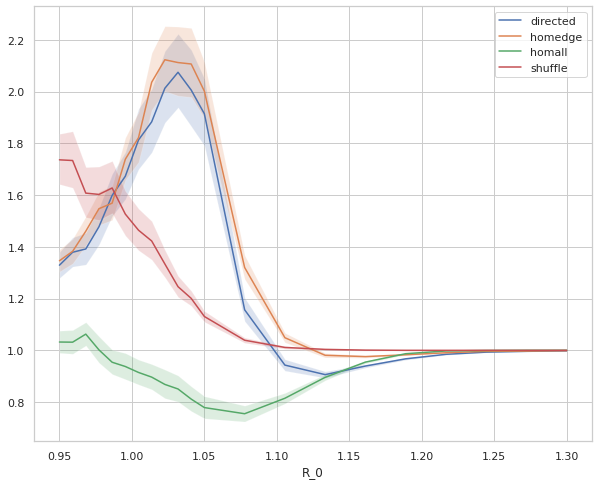

In [32]:
plt.figure(figsize=(10,8))

for label in ["directed", "homedge", "homall", "shuffle"]:
#for label in ["undirected", "homedge", "homall", "shuffle"]:
    
    df = pd.read_csv("simulations_130/KSH_{}_nodeTh:{}_edgeTh:{}.csv".format(
        label,KSH_args["th"]["node"], 25))
    betas = df["betas"]
    plt.plot(betas/args["--gamma"], df["mean1"]/df["mean2"], label=label)
    plt.fill_between(betas/args["--gamma"], df["lower"], df["upper"],alpha=0.2 )
    
plt.xlabel("R_0")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))

#for label in ["directed", "homedge"]:
for label in ["directed", "homedge", "homall", "shuffle"]:
    
    df = pd.read_csv("simulations/KSH_{}_nodeTh:{}_edgeTh:{}.csv".format(
        label,KSH_args["th"]["node"], 25))
    betas = df["betas"]
    plt.plot(betas/args["--gamma"], df["mean1"]/df["mean2"], label=label)
    
plt.xlabel("R_0")
plt.legend()
plt.show()

In [ ]:
len(pest)//2

In [ ]:
1/0

In [ ]:
plt.figure(figsize=(10,8))
#plt.ylim([0.9,2.0])

#for file in ["GIRG_tau:2.5_alpha:2.3.csv", "GIRG_tau:3_alpha:1.3.csv",
#             "GIRG_tau:3.5_alpha:1.3.csv", "GIRG_tau:3.5_alpha:2.3.csv"]:
for file in ["Config_tau:2.5_alpha:2.3.csv", "Config_tau:3_alpha:1.3.csv",
             "Config_tau:3.5_alpha:1.3.csv", "Config_tau:3.5_alpha:2.3.csv"]:
    df = pd.read_csv(file)
    plt.plot(df["betas"]/args["--gamma"], df["ratio"], label=file)
plt.xlabel("R_0")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
#plt.ylim([0.9,2.0])

#for file in ["GIRG_tau:2.5_alpha:2.3.csv", "GIRG_tau:3_alpha:1.3.csv",
#             "GIRG_tau:3.5_alpha:1.3.csv", "GIRG_tau:3.5_alpha:2.3.csv"]:
#for file in ["Config_tau:2.5_alpha:2.3.csv", "Config_tau:3_alpha:1.3.csv",
#             "Config_tau:3.5_alpha:1.3.csv", "Config_tau:3.5_alpha:2.3.csv"]:
for file in ["GIRG_tau:2.5_alpha:2.3.csv", "GIRG_tau:3_alpha:1.3.csv"]:
    df = pd.read_csv(file)
    plt.plot(df["betas"]/args["--gamma"], df["ratio"], label=file)
plt.xlabel("R_0")
plt.legend()
plt.show()